### Collecting data and processing data funcs:
Run this cell (select, then shift+enter)

In [4]:
#@title
from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns

sns.set_style("whitegrid")


def make_deep_requests(url, depth=5, limit=1000, sleep_time=2, stop_id=None):

    last_id = None
    data = pd.DataFrame()

    for counter in tqdm(range(depth)):
        if last_id:
            url += f'&lastId={last_id}'

        try:
            response = requests.get(url)
            new_data = json_normalize(json.loads(response.text))
            data = data.append(new_data)

        except Exception as exception:
            print(exception)
            import pdb; pdb.set_trace()

        last_id = data.id.iloc[-1]

        if len(new_data) < limit:
            break

        if stop_id in data['id'].values:
            break

        time.sleep(sleep_time)

    return data


def process_pool_data(df, token_decimals=6):

    convert = {
        'value.storage.tez_pool': lambda x: float(x) / 1_000_000,
        'value.storage.token_pool': lambda x: float(x) / (10**token_decimals),
        'timestamp': pd.Timestamp
    }

    for column_name, mapper in convert.items():
        df[column_name] = df[column_name].map(mapper)

    df['rate'] = df['value.storage.tez_pool'] / df['value.storage.token_pool']
    df = df.set_index('timestamp')
    return df


def collect_storage_history(smart_contract, depth=1):
    url = f'https://api.tzkt.io/v1/contracts/{smart_contract}/storage/history?limit=1000'
    return make_deep_requests(url, depth=depth)

### Requesting data:

In [6]:
# Insert here QuipuSwap contract that used to trade:
quipuswap_contract = 'KT1QxLqukyfohPV5kPkw97Rs6cw1DDDvYgbB'  # hDAO contract QuipuSwap v1.2

# Set requests depth if there are needed more than one request to pull all data:
requests_depth = 1
data = process_pool_data(
    collect_storage_history(quipuswap_contract, depth=requests_depth))

100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


### Plot price dynamics:

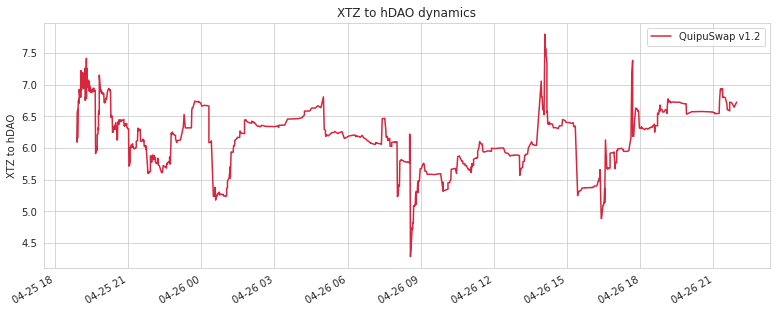

In [18]:
data.rate.rename('QuipuSwap v1.2').plot(color='#D7263D', figsize=(13,5))

plt.xlabel("")
plt.ylabel("XTZ to hDAO")
plt.legend()
_ = plt.title('XTZ to hDAO dynamics')

# If you want to save plot, uncomment this line:
# plt.savefig('test.png')

### Plotting pools data:

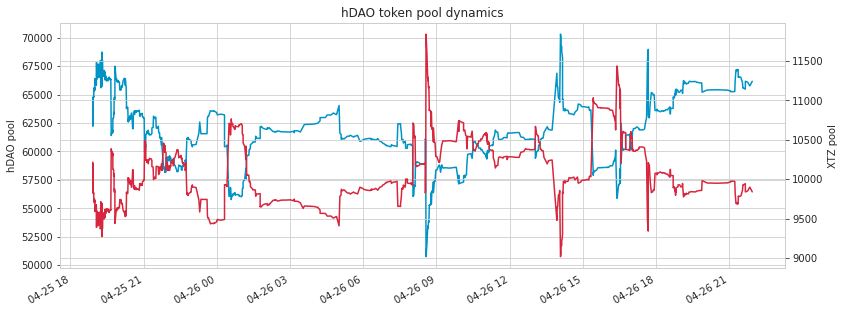

In [33]:
ax1 = data['value.storage.tez_pool'].plot(figsize=(13,5), color='#0094C6')
ax1.set_ylabel('hDAO pool')
ax2 = ax1.twinx()
ax2.set_ylabel('XTZ pool')
data['value.storage.token_pool'].plot(ax=ax2, color='#D7263D')

ax1.set_xlabel("")
_ = plt.title('hDAO token pool dynamics')